In [1]:
import xarray as xr
import torch
import numpy as np
import os
import json
import copy
import numpy as np
import shutil
from scipy.io import netcdf


from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid


'''
os.system("jupyter nbconvert --to script 'climate_train.ipynb'")
os.system("jupyter nbconvert --to script 'climate_data.ipynb'")
os.system("jupyter nbconvert --to script 'climate_models.ipynb'")
os.system("jupyter nbconvert --to script 'climate_job_maintenance.ipynb'")'''

import climate_train as ct
import climate_data
import climate_models
import climate_job_maintenance as cjm

def longitude_average(R2):
    mr2=np.zeros((R2.shape[0],R2.shape[1]))
    sr2=np.zeros((R2.shape[0],R2.shape[1]))
    for t in range(R2.shape[0]*R2.shape[1]):
        i=t%R2.shape[0]
        j=t//R2.shape[0]
        rr=R2[i,j]
        rr=rr[rr>0]
        rr[rr>1]=1
        with np.errstate(divide='ignore'):
            if len(rr)>0:
                mr2[i,j]=np.mean(rr)
                sr2[i,j]=np.std(rr)
    return mr2,sr2
def longitude_full_average(R2):
    mr2=np.zeros(R2.shape[0])
    sr2=np.zeros(R2.shape[0])
    for t in range(R2.shape[0]):
        rr=R2[t]
        rr=rr[rr>0]
        rr[rr>1]=1
        with np.errstate(divide='ignore'):
            if len(rr)>0:
                mr2[t]=np.mean(rr)
                sr2[t]=np.std(rr)
    return mr2,sr2
def code2vals(num,C):
    T=[]
    for i in range(len(C)):
        T.append(num%C[i])
        num=num//C[i]
    return T

In [2]:
args=ct.options(string_input="-b 3".split())
offset=0
args.model_id=offset
args.model_bank_id="G"

C,names=climate_models.golden_model_bank(args,only_description=True,verbose=True)

depth test 0
	temp
		yes - no - 
	res
		no - yes - 
	geophys
		no - yes - 
	training-depth
		0 - 1 - 2 - 3 - 4 - 5 - 6 - 
	sigma
		4 - 8 - 12 - 16 - 


In [3]:
offset=0
x=[[0],[0,1],[1],np.arange(6).tolist(),np.arange(4).tolist()]
J=cjm.jobnums(C=C,x=x,offset=offset)

lines=['PKP','4 regions','global','global+temperature','global+coordinates','global+temperature+PKP']
ranks=[]
ranks+=[0,1,3,5]

In [4]:
ls /scratch/zanna/data/cm2.6/

1pct-CO2-3D-data.zarr/                    coarse-3D-data-sigma-16.zarr/
1pct-CO2-surf-data.zarr/                  coarse-3D-data-sigma-4.zarr/
1pct_co2/                                 coarse-3D-data-sigma-6.zarr/
3D-data.zarr/                             coarse-3D-data-sigma-8.zarr/
Grid_Files/                               coarse-surf-data-sigma-10.zarr/
coarse-1pct-CO2-3D-data-sigma-12.zarr/    coarse-surf-data-sigma-12.zarr/
coarse-1pct-CO2-3D-data-sigma-16.zarr/    coarse-surf-data-sigma-14.zarr/
coarse-1pct-CO2-3D-data-sigma-4.zarr/     coarse-surf-data-sigma-16.zarr/
coarse-1pct-CO2-3D-data-sigma-8.zarr/     coarse-surf-data-sigma-4.zarr/
coarse-1pct-CO2-surf-data-sigma-12.zarr/  coarse-surf-data-sigma-6.zarr/
coarse-1pct-CO2-surf-data-sigma-16.zarr/  coarse-surf-data-sigma-8.zarr/
coarse-1pct-CO2-surf-data-sigma-4.zarr/   geometry/
coarse-1pct-CO2-surf-data-sigma-8.zarr/   info.txt*
coarse-3D-data-sigma-10.zarr/             picontrol/
coarse-3D-data-sigma-12.zarr/             s

In [5]:
raw_data_address='/scratch/zanna/data/cm2.6/1pct-CO2-3D-data.zarr'
co2ds_data=xr.open_zarr(raw_data_address)

raw_data_address='/scratch/zanna/data/cm2.6/3D-data.zarr'
ds_data=xr.open_zarr(raw_data_address)

In [6]:
co2ds_data,ds_data

(<xarray.Dataset>
 Dimensions:         (nv: 2, st_edges_ocean: 51, st_ocean: 4, time: 1460, xt_ocean: 3600, xu_ocean: 3600, yt_ocean: 2700, yu_ocean: 2700)
 Coordinates:
   * nv              (nv) float64 1.0 2.0
   * st_edges_ocean  (st_edges_ocean) float64 0.0 10.07 ... 5.29e+03 5.5e+03
   * st_ocean        (st_ocean) float64 5.034 110.1 181.3 330.0
   * time            (time) object 0181-01-03 12:00:00 ... 0200-12-28 12:00:00
   * xt_ocean        (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.85 79.95
   * xu_ocean        (xu_ocean) float64 -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
   * yt_ocean        (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.94 89.98
   * yu_ocean        (yu_ocean) float64 -81.09 -81.05 -81.0 ... 89.92 89.96 90.0
 Data variables:
     temp            (time, st_ocean, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=np.ndarray>
     u               (time, st_ocean, yu_ocean, xu_ocean) float32 dask.array<chunksize=(1, 1, 2700, 3600), meta=

In [7]:
raw_data_address='/scratch/zanna/data/cm2.6/coarse-3D-data-sigma-4.zarr'
st_vals=xr.open_zarr(raw_data_address).st_ocean.values
st_vals=[int(ss) for ss in st_vals]

In [8]:
str_st_vals=[str(ss) for ss in st_vals]

In [9]:
root='/scratch/cg3306/climate/runs/'

In [10]:
MSE=np.load(root+'G-'+str(J[0])+'/MSE-depth.npy')

In [11]:
MSE.shape

(7, 3, 625, 900)

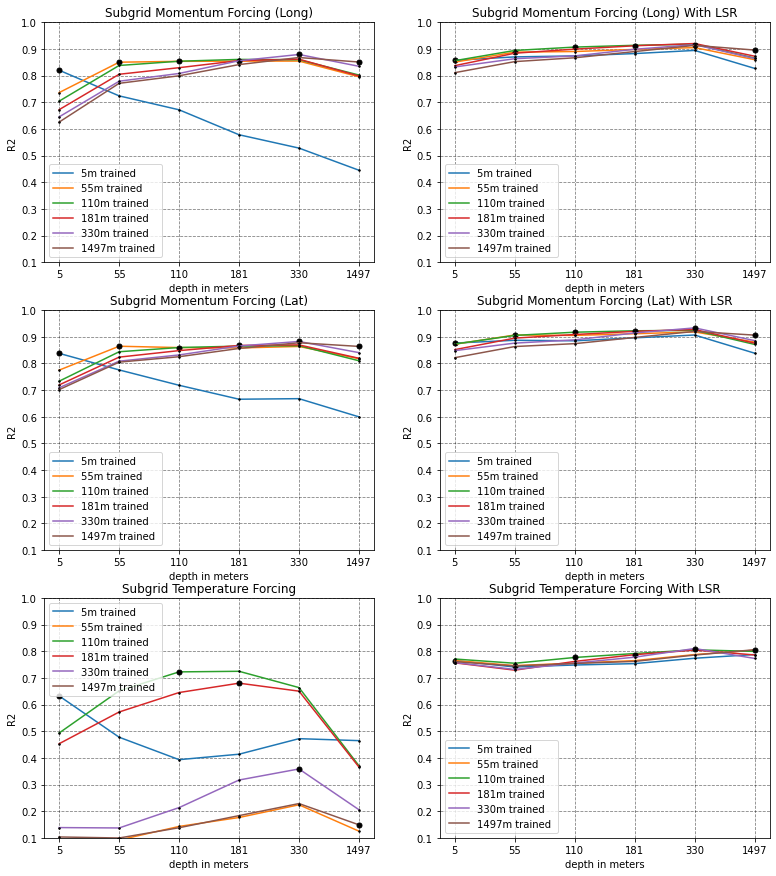

In [13]:
ncols=2
nchans=3
fig,axs=plt.subplots(nchans,ncols,figsize=(13,15))
fig.patch.set_facecolor('white')
datype=['Subgrid Momentum Forcing (Long)','Subgrid Momentum Forcing (Lat)','Subgrid Temperature Forcing']
root='/scratch/cg3306/climate/runs/'
for s in range(nchans):
    for j in range(ncols):
        x=[[0],[j],[1],np.arange(6).tolist(),[0]]
        J=cjm.jobnums(C=C,x=x,offset=offset)
        ax=axs[s,j]
        for k in range(len(J)):
    #         if k==0:
    #             MSELOC='/scratch/cg3306/climate/projection_analysis/surf-data-sigma-4MSE.npy'
    #             SC2LOC=MSELOC.replace('MSE','SC2')
    #             with np.errstate(divide='ignore'):
    #                 MSE=np.load(MSELOC)
    #                 SC2=np.load(SC2LOC)
    #             Z=SC2[j]
    #             Z[Z==0]=np.nan
    #             R2=1-MSE[:,j]/Z
    #             print(MSE.shape)
    #             mr2=np.zeros(R2.shape[0])
    #             sr2=mr2*1
    #             spread=(len(xx)-MSE.shape[1])//2
    #             for i in range(R2.shape[0]):
    #                 rr=R2
    #                 rr=rr[rr==rr]
    #                 rr=rr[rr>0]
    #                 rr[rr>1]=1
    #                 with np.errstate(divide='ignore'):
    #                     mr2[i]=np.mean(rr)
    #                     sr2[i]=np.std(rr)
    #         else:
            foldername='G-'+str(J[k])
            readfile=True
            try:
                with np.errstate(divide='ignore'):
                    MSE=np.load(root+foldername+'/MSE-depth.npy')
                    SC2=np.load(root+foldername+'/SC2-depth.npy')
            except:
                readfile=False
            if readfile:
                if MSE.shape[0]==0:
                    readfile=False
            if readfile:
                if s<MSE.shape[1]:
                    Z=SC2[:,s]
                    Z[Z==0]=np.nan
                    R2=1-MSE[:,s]/Z
                    mr2=np.zeros(R2.shape[0])
                    sr2=mr2*1
                    for i in range(R2.shape[0]):
                        rr=R2[i]
                        rr=rr[rr==rr]
                        rr=rr[rr>0]
                        rr[rr>1]=1
                        with np.errstate(divide='ignore'):
                            if len(rr)>0:
                                mr2[i]=np.mean(rr)
                                sr2[i]=np.std(rr)
                            else:
                                mr2[i]=np.nan
                                
                ax.plot(np.arange(6),mr2[:-1],label=str(st_vals[k])+'m trained ')
                ax.plot(np.arange(6),mr2[:-1],'k.',markersize=3)
                ax.plot([k],mr2[k],'k.',markersize=10)
                ax.set_xticks(np.arange(6))
                ax.set_xticklabels(str_st_vals[:-1])
                ax.set_ylabel('R2')
                ax.set_xlabel('depth in meters')
                title=datype[s]
                if j==1:
                    title+=' With LSR'
                ax.set_title(title)
                ax.set_ylim([0.1,1])
                ax.legend()
            else:
                print(root+foldername+'/MSE-depth.npy')
        ax.grid(color='k',linestyle='--',alpha=0.5)

In [9]:
ls /scratch/cg3306/climate/runs/G-0

best-model  last-model  log.json


In [22]:
root+foldername+'/MSE-depth.npy'

'/scratch/cg3306/climate/runs/G-60/MSE-depth.npy'

In [13]:
args.data_address

'/scratch/ag7531/mlruns/19/bae994ef5b694fc49981a0ade317bf07/artifacts/forcing/'

In [29]:
MSE=np.load('/scratch/cg3306/climate/runs/G-214/MSE-depth.npy')

In [2]:
args=ct.options(string_input="-b 3".split())
offset=0
args.model_id=214
args.depth=1
args.model_bank_id="G"

In [3]:
net,criterion,(data_init,partition),logs,(PATH0,PATH1,LOG,root)=ct.load_from_save(args)
(training_set,training_generator),(val_set,val_generator),(test_set,test_generator),(dataset,glbl_gen)=ct.load_data(data_init,partition,args)
residue_flag=dataset.outputs[0]=='Su_r'
if residue_flag:
    numoutputs=len(dataset.outputs)
    dataset.outputs+=[ss.replace('_r','') for ss in dataset.outputs]
    dataset.outscales=dataset.outscales*2
if isinstance(net, climate_models.RegressionModel):
    w=linear_model_fit(root)
device=ct.get_device()
net.eval()
if args.co2:
    MSELOC=root+'/MSE-co2.npy'
    SC2LOC=root+'/SC2-co2.npy'
else:
    MSELOC=root+'/MSE.npy'
    SC2LOC=root+'/SC2.npy'

spread=net.spread
noutsig=net.outwidth



if args.depth:
    MSELOC=MSELOC.replace('.npy','-depth.npy')
    SC2LOC=SC2LOC.replace('.npy','-depth.npy')
    numdepths=len(training_set.depthvals)
else:
    numdepths=1

MSE=torch.zeros(numdepths,noutsig,dataset.dimens[0]-spread*2, dataset.dimens[1]-spread*2)
#LIKE=torch.zeros(noutsig,dataset.dimens[0]-spread*2, dataset.dimens[1]-spread*2)
SC2=torch.zeros(numdepths,noutsig,dataset.dimens[0]-spread*2, dataset.dimens[1]-spread*2)
print(MSELOC)
arr=np.arange(len(dataset))
np.random.shuffle(arr)

LCNN + 5x5 + deep (1498m) + res + glbl + lat + coarse(16) + batch= 32


/ext3/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


domain id: 3
Loaded the existing model
/scratch/cg3306/climate/runs/G-214/MSE-depth.npy


In [8]:
X,M,Y=dataset[0]

In [12]:
X.shape,Y.shape,dataset.spread

(torch.Size([5, 161, 229]), torch.Size([6, 157, 225]), 2)

In [10]:
dataset.ds_data

<xarray.Dataset>
Dimensions:       (st_ocean: 7, time: 64, xu_ocean: 225, yu_ocean: 161)
Coordinates:
  * st_ocean      (st_ocean) float64 5.034 55.85 110.1 ... 1.498e+03 3.509e+03
  * time          (time) int64 0 1 2 3 4 5 6 7 8 ... 55 56 57 58 59 60 61 62 63
  * xu_ocean      (xu_ocean) float64 -279.1 -277.5 -275.9 ... 76.05 77.65 79.25
  * yu_ocean      (yu_ocean) float64 -80.77 -80.09 -79.42 ... 83.09 83.77 84.45
Data variables:
    ST            (time, st_ocean, yu_ocean, xu_ocean) float64 dask.array<chunksize=(16, 7, 161, 225), meta=np.ndarray>
    ST_LH         (time, st_ocean, yu_ocean, xu_ocean) float64 dask.array<chunksize=(16, 7, 161, 225), meta=np.ndarray>
    ST_r          (time, st_ocean, yu_ocean, xu_ocean) float64 dask.array<chunksize=(16, 7, 161, 225), meta=np.ndarray>
    Su            (time, st_ocean, yu_ocean, xu_ocean) float64 dask.array<chunksize=(16, 7, 161, 225), meta=np.ndarray>
    Su_LH         (time, st_ocean, yu_ocean, xu_ocean) float64 dask.array<chunksize=(16, 7, 161, 225), meta=np.ndarray>
    Su_r          (time, st_ocean, yu_ocean, xu_ocean) float64 dask.array<chunksize=(16, 7, 161, 225), meta=np.ndarray>
    Sv            (time, st_ocean, yu_ocean, xu_ocean) float64 dask.array<chunksize=(16, 7, 161, 225), meta=np.ndarray>
    Sv_LH         (time, st_ocean, yu_ocean, xu_ocean) float64 dask.array<chunksize=(16, 7, 161, 225), meta=np.ndarray>
    Sv_r          (time, st_ocean, yu_ocean, xu_ocean) float64 dask.array<chunksize=(16, 7, 161, 225), meta=np.ndarray>
    surface_temp  (time, st_ocean, yu_ocean, xu_ocean) float64 dask.array<chunksize=(16, 7, 161, 225), meta=np.ndarray>
    usurf         (time, st_ocean, yu_ocean, xu_ocean) float64 dask.array<chunksize=(16, 7, 161, 225), meta=np.ndarray>
    vsurf         (time, st_ocean, yu_ocean, xu_ocean) float64 dask.array<chunksize=(16, 7, 161, 225), meta=np.ndarray>

In [ ]:
for di in range(len(dataset)*numdepths):
    i=di%len(dataset)
    depthind=di//len(dataset)
    if args.depth:
        dataset.depthind=depthind
        uv,Sxy=dataset.input_output(arr[i],scale=False,periodic_lon_expand=True)
        if i==0:
            training_set.depthind=depthind
            insc,outsc=training_set.compute_scales()
            insc,outsc=np.reshape(insc,[-1,1,1]),np.reshape(outsc,[-1,1,1])
            if residue_flag:
                outsc=np.concatenate([outsc,outsc],axis=0)
        uv[:insc.shape[0]]=uv[:insc.shape[0]]/insc
        Sxy[:outsc.shape[0]]=Sxy[:outsc.shape[0]]/outsc
        uv[uv!=uv]=0
        Sxy[Sxy!=Sxy]=0
        uv,Sxy=dataset.pad_with_zero(uv,0),dataset.pad_with_zero(Sxy,dataset.spread)
    else:
        uv,_,Sxy=dataset[arr[i]]
    if residue_flag:
        Sxy1,Sxy=torch.split(Sxy,[numoutputs,numoutputs],dim=0)
    uv=torch.stack([uv]).to(device)
    #net.set_coarsening(0)
    with torch.set_grad_enabled(False):
        if isinstance(net, climate_models.RegressionModel):
            output=net.forward(uv,w)
        else:
            output=net.forward(uv)
    output=output[0].to(torch.device("cpu"))
    output,prec,_=torch.split(output,[noutsig,net.nprecision,output.shape[0]-noutsig-net.nprecision],dim=0)


    SC2[depthind]=SC2[depthind] + Sxy**2
    if residue_flag:
        MSE[depthind]=MSE[depthind] + (Sxy1-output)**2
    else:
        MSE[depthind]=MSE[depthind] + (Sxy-output)**2
    if di%10==0:
        MSE_=MSE.numpy()/(i+1)
        SC2_=SC2.numpy()/(i+1)

        with open(MSELOC, 'wb') as f:
            np.save(f, MSE_)
        with open(SC2LOC, 'wb') as f:
            np.save(f, SC2_)
        if not args.depth:
            print('\t #'+str(i),flush=True)
        else:
            print('\t depth# '+str(depthind)+', time# '+str(i),flush=True)

MSE_=MSE.numpy()/len(dataset)
SC2_=SC2.numpy()/len(dataset)

with open(MSELOC, 'wb') as f:
    np.save(f, MSE_)
with open(SC2LOC, 'wb') as f:
    np.save(f, SC2_)
print('analysis is done',flush=True)